In [1]:
start_date_str = "2012-01-01"
end_date_str = "2022-12-31"
period = 250

factor_file = "./data/CN_AFNS_Factor.csv"
feature_file ="./data/clean_features/all_features.csv"
result_file = "./data/ML_Pred_AFNS_Factor_1Y.csv"


In [2]:
from pathlib import Path

import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor
from pyearth.earth import Earth

In [3]:
import warnings


warnings.simplefilter("ignore")

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

%config InlineBackend.figure_format = 'retina'


In [4]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None
        
    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index = X_1.index,
            columns = y.columns,
        )
        
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze()
        
        self.model_2.fit(X_2, y_resid)
        
        self.y_columns = y.columns
        self.y_fit = y_fit
        self.y_resid = y_resid
        
    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index = X_1.index,
            columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()
        
        y_pred += self.model_2.predict(X_2)
        
        return y_pred

## 1.数据处理

In [5]:
start_date = datetime.datetime.strptime(start_date_str, "%Y-%m-%d")
end_date = datetime.datetime.strptime(end_date_str, "%Y-%m-%d")
print(start_date, end_date)

2012-01-01 00:00:00 2022-12-31 00:00:00


In [6]:
raw_y =  pd.read_csv(factor_file, index_col='Date', parse_dates=['Date'])
raw_X =  pd.read_csv(feature_file, index_col='Date', parse_dates=['Date'])

raw_X = raw_X[(raw_X.index>=start_date) & (raw_X.index<=end_date)]
raw_X




,CN_GDP_Current_Price_Cum_YTY,CN_GDP_Constant_Price_Cum_YTY,CN_GDP_Deflator_GDP_Cum_YTY,CN_GDP_Constant_Current_Q,CN_IFA_Cum_MTM,CN_IE_FGI_MTM,CN_PMI_New_Order,CN_PMI_RMP,CN_TRSCG_Cum_MOM,CN_PFE_MOM,...,LIBORO/N,LIBOR1W,LIBOR1M,LIBOR2M,LIBOR3M,LIBOR6M,LIBOR12M,CN_New_Jobs_Cum,CN_Difficulty_Cum,CN_Reemployed_Cum
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,18.5,11.0800,...,0.15000,0.20720,0.29530,0.4282,0.58250,0.81100,1.13035,1221.0,0.0,0.0
2012-01-05,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,18.5,11.0800,...,0.14950,0.20620,0.29530,0.4292,0.58250,0.81200,1.13035,1221.0,0.0,0.0
2012-01-06,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,18.5,11.0800,...,0.14900,0.20620,0.29630,0.4282,0.58150,0.81200,1.13035,1221.0,0.0,0.0
2012-01-09,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,18.5,11.0800,...,0.14900,0.20620,0.29630,0.4282,0.58050,0.81000,1.12825,1221.0,0.0,0.0
2012-01-10,18.49,9.550832,8.0272,127039.6,23.8,20.78,49.8,47.1,18.5,11.0800,...,0.15000,0.20420,0.29580,0.4282,0.57950,0.80850,1.12605,1221.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,5.73,3.000000,3.1439,289504.9,5.3,11.40,46.4,50.7,-0.1,4.7989,...,4.31671,0.07638,4.38686,0.1525,4.72643,5.15314,5.44386,1145.0,163.0,476.0
2022-12-27,5.73,3.000000,3.1439,289504.9,5.3,11.40,46.4,50.7,-0.1,4.7989,...,4.31671,0.07638,4.38686,0.1525,4.72643,5.15314,5.44386,1145.0,163.0,476.0
2022-12-28,5.73,3.000000,3.1439,289504.9,5.3,11.40,46.4,50.7,-0.1,4.7989,...,4.31643,0.07638,4.38357,0.1525,4.72986,5.15114,5.47029,1145.0,163.0,476.0


In [7]:
# raw_X = raw_X[:500]
# raw_y = raw_y[:500]

In [8]:
print(raw_X.shape, raw_y.shape)

(2744, 182) (2744, 3)


In [9]:
# 由于是预测未来Period天的，所以需要将X进行移动
X = raw_X.shift(period).dropna()
X, y = X.align(raw_y, join="inner", axis=0)


In [10]:
print(X.shape, y.shape)

(2494, 182) (2494, 3)


## 2.Level建模

In [11]:
def get_beta_data(X, y, label):
    beta_y = y[[label]]

    trend_beta = beta_y.rolling(window = 20, center = True, min_periods = 5).mean()
    trend_beta.columns = ['trend']
    beta_X_1 = trend_beta

    beta_X_2 = X
    
    return beta_X_1, beta_X_2, beta_y
    

def get_beta_train_and_test_data(beta_X_1, beta_X_2, beta_y):
    
    # 训练集: 测试集 = 8：2
    data_ratio = 0.8
    N = beta_y.shape[0]
    length = int(data_ratio * N)

    beta_train_X_1 = beta_X_1[:length]
    beta_train_X_2 = beta_X_2[:length]
    beta_train_y = beta_y[:length]



    beta_test_X_1 = beta_X_1[length:]
    beta_test_X_2 = beta_X_2[length:]
    beta_test_y = beta_y[length:]
    return beta_train_X_1, beta_train_X_2, beta_train_y, beta_test_X_1, beta_test_X_2, beta_test_y


beta0_X_1, beta0_X_2, beta0_y = get_beta_data(X, y, "Level")

beta0_train_X_1, beta0_train_X_2, beta0_train_y, beta0_test_X_1, beta0_test_X_2, beta0_test_y = get_beta_train_and_test_data(beta0_X_1, beta0_X_2, beta0_y)


In [12]:
print(beta0_train_X_1.shape, beta0_train_X_2.shape, beta0_train_y.shape)

(1995, 1) (1995, 182) (1995, 1)


In [13]:
# 单步预测
def predict_beta(train_len, test_len, beta_X_1, beta_X_2, beta_y):
    all_len = train_len + test_len


    result_list = []
    for i in range(train_len, all_len, 1):
        print(i, all_len)
        use_beta_train_X_1 = beta_X_1[:i]
        use_beta_train_X_2 = beta_X_2[:i]
        use_beta_train_y = beta_y[:i]

        use_beta_test_X_1 = beta_X_1[i:i+1]
        use_beta_test_X_2 = beta_X_2[i:i+1]
        #temp_model = BoostedHybrid(model_1 = LinearRegression(), model_2 = XGBRegressor(),)
        temp_model = BoostedHybrid(model_1 = LinearRegression(), model_2 = XGBRegressor(),)
        temp_model.fit(use_beta_train_X_1, use_beta_train_X_2, use_beta_train_y)
        temp_value = temp_model.predict(use_beta_test_X_1, use_beta_test_X_2).mean()
        result_list.append(temp_value)
    
    return result_list


train_len = beta0_train_y.shape[0]
test_len = beta0_test_y.shape[0]
beta0_predict_list = predict_beta(train_len, test_len, beta0_X_1, beta0_X_2, beta0_y)
beta0_predict_list

1995 2494
1996 2494
1997 2494
1998 2494
1999 2494
2000 2494
2001 2494
2002 2494
2003 2494
2004 2494
2005 2494
2006 2494
2007 2494
2008 2494
2009 2494
2010 2494
2011 2494
2012 2494
2013 2494
2014 2494
2015 2494
2016 2494
2017 2494
2018 2494
2019 2494
2020 2494
2021 2494
2022 2494
2023 2494
2024 2494
2025 2494
2026 2494
2027 2494
2028 2494
2029 2494
2030 2494
2031 2494
2032 2494
2033 2494
2034 2494
2035 2494
2036 2494
2037 2494
2038 2494
2039 2494
2040 2494
2041 2494
2042 2494
2043 2494
2044 2494
2045 2494
2046 2494
2047 2494
2048 2494
2049 2494
2050 2494
2051 2494
2052 2494
2053 2494
2054 2494
2055 2494
2056 2494
2057 2494
2058 2494
2059 2494
2060 2494
2061 2494
2062 2494
2063 2494
2064 2494
2065 2494
2066 2494
2067 2494
2068 2494
2069 2494
2070 2494
2071 2494
2072 2494
2073 2494
2074 2494
2075 2494
2076 2494
2077 2494
2078 2494
2079 2494
2080 2494
2081 2494
2082 2494
2083 2494
2084 2494
2085 2494
2086 2494
2087 2494
2088 2494
2089 2494
2090 2494
2091 2494
2092 2494
2093 2494
2094 2494


[7.644379,
 7.640732,
 7.6350474,
 7.630894,
 7.623591,
 7.6181116,
 7.613195,
 7.6053076,
 7.597694,
 7.592371,
 7.587478,
 7.5814123,
 7.574261,
 7.5716596,
 7.565428,
 7.562461,
 7.5564933,
 7.5536585,
 7.549199,
 7.5457096,
 7.5435896,
 7.538874,
 7.533697,
 7.5390363,
 7.5328765,
 7.529544,
 7.5250626,
 7.523597,
 7.522867,
 7.520903,
 7.5168877,
 7.5153813,
 7.5121193,
 7.507569,
 7.5109305,
 7.5083494,
 7.5058355,
 7.501446,
 7.498966,
 7.496431,
 7.4939623,
 7.490047,
 7.4879756,
 7.489784,
 7.480475,
 7.4812455,
 7.476365,
 7.473532,
 7.470303,
 7.4679914,
 7.467634,
 7.467115,
 7.462363,
 7.4596257,
 7.4595776,
 7.457281,
 7.4574947,
 7.4524364,
 7.453191,
 7.4472957,
 7.448779,
 7.4440036,
 7.446235,
 7.4431777,
 7.4385695,
 7.435236,
 7.432388,
 7.431267,
 7.428656,
 7.425335,
 7.4246173,
 7.4223666,
 7.4184866,
 7.417056,
 7.4116917,
 7.4085407,
 7.4040623,
 7.3976326,
 7.396075,
 7.389339,
 7.385714,
 7.3841033,
 7.3777747,
 7.3739543,
 7.369985,
 7.3655796,
 7.3591375,
 

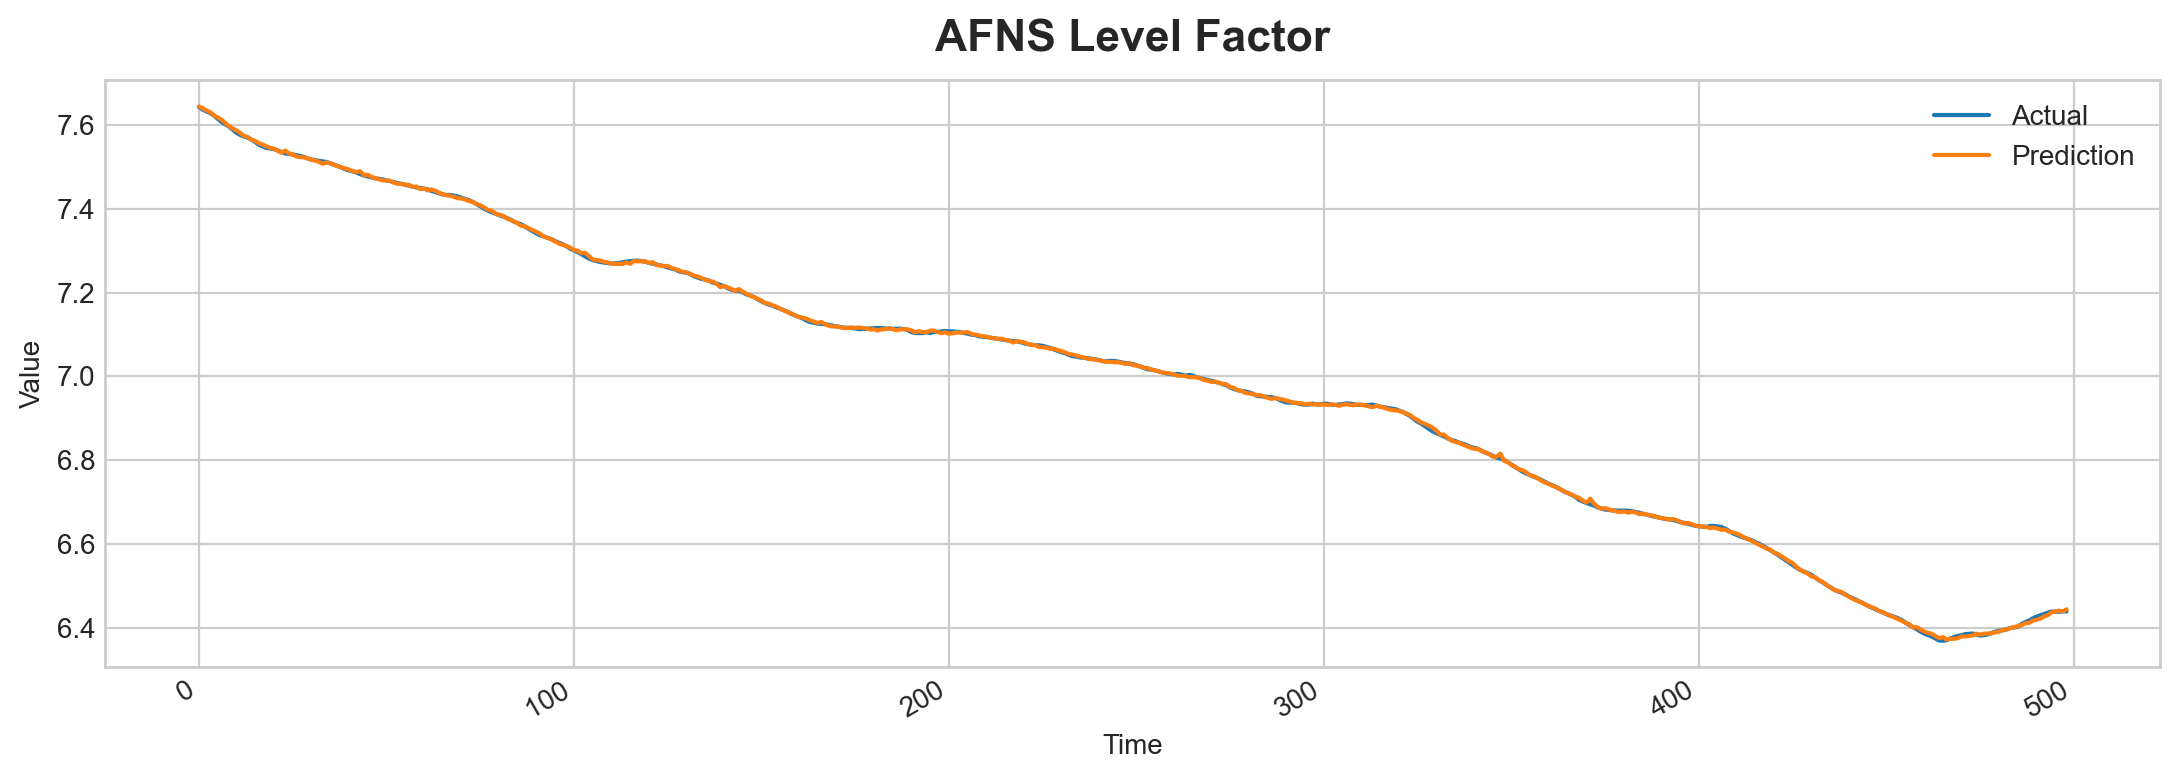

In [26]:
def plot_predict(atual_value, predict_value, label="Beta0"):
    fig, ax = plt.subplots()

    ax.plot(atual_value, label="Actual")
    ax.plot(predict_value, label="Prediction")
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

    plt.title(f"AFNS {label} Factor")
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.legend()
    
plot_predict(beta0_test_y.values, beta0_predict_list, label="Level")

## 3.Slope建模

In [15]:
beta1_X_1, beta1_X_2, beta1_y = get_beta_data(X, y, "Slope")

beta1_train_X_1, beta1_train_X_2, beta1_train_y, \
    beta1_test_X_1, beta1_test_X_2, beta1_test_y = get_beta_train_and_test_data(beta1_X_1, beta1_X_2, beta1_y)


In [16]:
print(beta1_train_X_1.shape, beta1_train_X_2.shape, beta1_train_y.shape)

(1995, 1) (1995, 182) (1995, 1)


In [17]:
train_len = beta1_train_y.shape[0]
test_len = beta1_test_y.shape[0]
beta1_predict_list = predict_beta(train_len, test_len, beta1_X_1, beta1_X_2, beta1_y)
beta1_predict_list

1995 2494
1996 2494
1997 2494
1998 2494
1999 2494
2000 2494
2001 2494
2002 2494
2003 2494
2004 2494
2005 2494
2006 2494
2007 2494
2008 2494
2009 2494
2010 2494
2011 2494
2012 2494
2013 2494
2014 2494
2015 2494
2016 2494
2017 2494
2018 2494
2019 2494
2020 2494
2021 2494
2022 2494
2023 2494
2024 2494
2025 2494
2026 2494
2027 2494
2028 2494
2029 2494
2030 2494
2031 2494
2032 2494
2033 2494
2034 2494
2035 2494
2036 2494
2037 2494
2038 2494
2039 2494
2040 2494
2041 2494
2042 2494
2043 2494
2044 2494
2045 2494
2046 2494
2047 2494
2048 2494
2049 2494
2050 2494
2051 2494
2052 2494
2053 2494
2054 2494
2055 2494
2056 2494
2057 2494
2058 2494
2059 2494
2060 2494
2061 2494
2062 2494
2063 2494
2064 2494
2065 2494
2066 2494
2067 2494
2068 2494
2069 2494
2070 2494
2071 2494
2072 2494
2073 2494
2074 2494
2075 2494
2076 2494
2077 2494
2078 2494
2079 2494
2080 2494
2081 2494
2082 2494
2083 2494
2084 2494
2085 2494
2086 2494
2087 2494
2088 2494
2089 2494
2090 2494
2091 2494
2092 2494
2093 2494
2094 2494


[-5.306636,
 -5.244631,
 -5.2442474,
 -5.2451577,
 -5.273683,
 -5.268245,
 -5.3067403,
 -5.271033,
 -5.307332,
 -5.3312097,
 -5.34204,
 -5.285777,
 -5.2911644,
 -5.2976513,
 -5.3056803,
 -5.2268744,
 -5.2554393,
 -5.2044387,
 -5.194199,
 -5.130405,
 -5.11326,
 -5.128931,
 -5.1166573,
 -5.0813017,
 -5.050569,
 -5.0751224,
 -4.9547596,
 -4.9749737,
 -5.0080795,
 -5.010977,
 -5.0263805,
 -5.0350394,
 -5.0339108,
 -5.0160174,
 -5.058823,
 -5.048407,
 -5.0409274,
 -5.02867,
 -5.0762205,
 -5.055571,
 -5.0805845,
 -5.1192102,
 -5.0352216,
 -5.050645,
 -5.0136495,
 -5.0451407,
 -5.024221,
 -4.982709,
 -5.0137115,
 -4.983524,
 -4.981582,
 -4.996752,
 -4.917923,
 -4.991789,
 -4.969485,
 -5.0133653,
 -5.0184793,
 -4.9871063,
 -5.0441375,
 -4.9941053,
 -5.0411787,
 -5.0172687,
 -5.003539,
 -5.041623,
 -5.0452814,
 -5.046918,
 -4.9978213,
 -4.9930973,
 -5.040402,
 -5.061374,
 -5.036678,
 -5.0536723,
 -5.0690074,
 -5.054869,
 -5.0746465,
 -5.0883317,
 -5.0867386,
 -5.07972,
 -5.102852,
 -5.0677843,


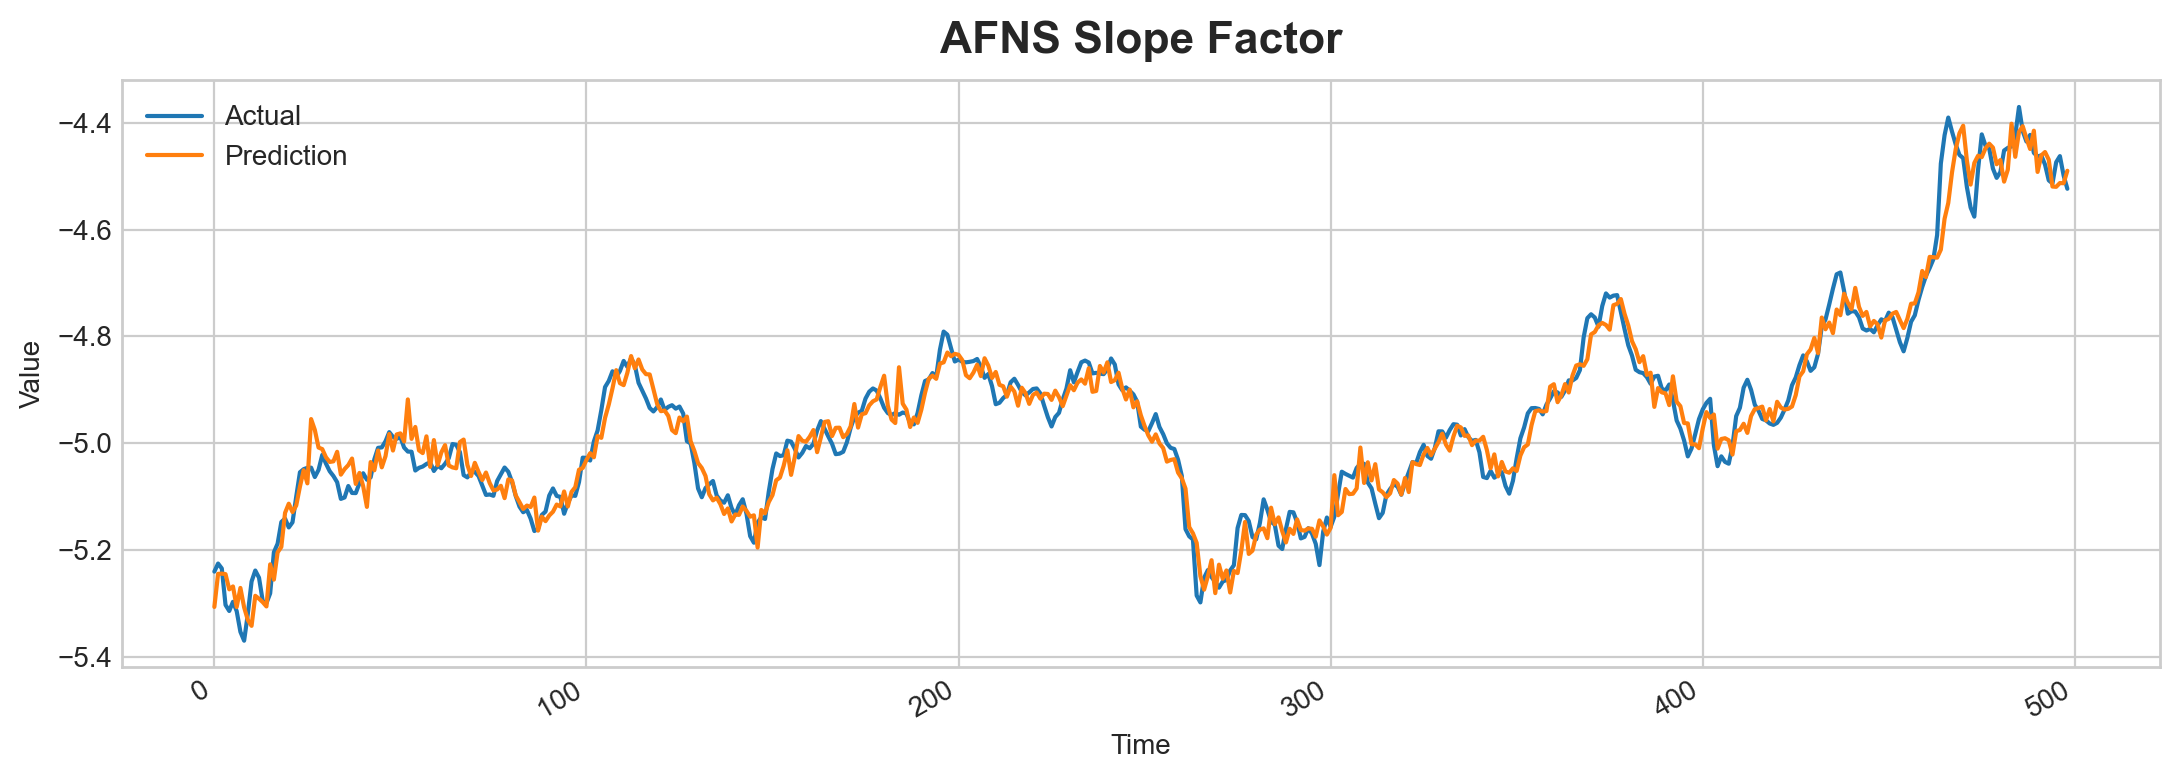

In [27]:
plot_predict(beta1_test_y.values, beta1_predict_list, label="Slope")

In [19]:
print(len(beta1_test_y.values), len(beta1_predict_list))

499 499


## Curvature 预测


In [20]:
beta2_X_1, beta2_X_2, beta2_y = get_beta_data(X, y, "Curvature")

beta2_train_X_1, beta2_train_X_2, beta2_train_y, \
    beta2_test_X_1, beta2_test_X_2, beta2_test_y = get_beta_train_and_test_data(beta2_X_1, beta2_X_2, beta2_y)

In [21]:
print(beta2_train_X_1.shape, beta2_train_X_2.shape, beta2_train_y.shape)

(1995, 1) (1995, 182) (1995, 1)


In [22]:
train_len = beta2_train_y.shape[0]
test_len = beta2_test_y.shape[0]
beta2_predict_list = predict_beta(train_len, test_len, beta2_X_1, beta2_X_2, beta2_y)
beta2_predict_list

1995 2494
1996 2494
1997 2494
1998 2494
1999 2494
2000 2494
2001 2494
2002 2494
2003 2494
2004 2494
2005 2494
2006 2494
2007 2494
2008 2494
2009 2494
2010 2494
2011 2494
2012 2494
2013 2494
2014 2494
2015 2494
2016 2494
2017 2494
2018 2494
2019 2494
2020 2494
2021 2494
2022 2494
2023 2494
2024 2494
2025 2494
2026 2494
2027 2494
2028 2494
2029 2494
2030 2494
2031 2494
2032 2494
2033 2494
2034 2494
2035 2494
2036 2494
2037 2494
2038 2494
2039 2494
2040 2494
2041 2494
2042 2494
2043 2494
2044 2494
2045 2494
2046 2494
2047 2494
2048 2494
2049 2494
2050 2494
2051 2494
2052 2494
2053 2494
2054 2494
2055 2494
2056 2494
2057 2494
2058 2494
2059 2494
2060 2494
2061 2494
2062 2494
2063 2494
2064 2494
2065 2494
2066 2494
2067 2494
2068 2494
2069 2494
2070 2494
2071 2494
2072 2494
2073 2494
2074 2494
2075 2494
2076 2494
2077 2494
2078 2494
2079 2494
2080 2494
2081 2494
2082 2494
2083 2494
2084 2494
2085 2494
2086 2494
2087 2494
2088 2494
2089 2494
2090 2494
2091 2494
2092 2494
2093 2494
2094 2494


[-2.4670718,
 -2.451434,
 -2.4555008,
 -2.460987,
 -2.441818,
 -2.4072175,
 -2.3799639,
 -2.3454819,
 -2.3156886,
 -2.2710059,
 -2.2564569,
 -2.2414732,
 -2.261989,
 -2.2407756,
 -2.229699,
 -2.2228901,
 -2.24812,
 -2.240389,
 -2.2665207,
 -2.245222,
 -2.2652092,
 -2.2850895,
 -2.296136,
 -2.2805037,
 -2.2783237,
 -2.2727535,
 -2.2669742,
 -2.2678668,
 -2.271849,
 -2.2643824,
 -2.2010777,
 -2.2195568,
 -2.2013552,
 -2.1807468,
 -2.171338,
 -2.127129,
 -2.086923,
 -2.1213262,
 -2.098502,
 -2.0198283,
 -2.0084798,
 -2.0164149,
 -2.028006,
 -2.0140305,
 -2.0570483,
 -2.0383818,
 -2.0530512,
 -2.1001725,
 -2.0691557,
 -2.0841844,
 -2.1169426,
 -2.1225655,
 -2.1312253,
 -2.1343222,
 -2.1265154,
 -2.1393118,
 -2.0694613,
 -2.1294343,
 -2.1352208,
 -2.1633716,
 -2.097228,
 -2.1793087,
 -2.1482995,
 -2.130725,
 -2.0926204,
 -2.1222079,
 -2.134653,
 -2.106537,
 -2.10041,
 -2.1206887,
 -2.1203368,
 -2.130135,
 -2.1121745,
 -2.1227868,
 -2.1204154,
 -2.1010485,
 -2.0833576,
 -2.0628536,
 -2.04631

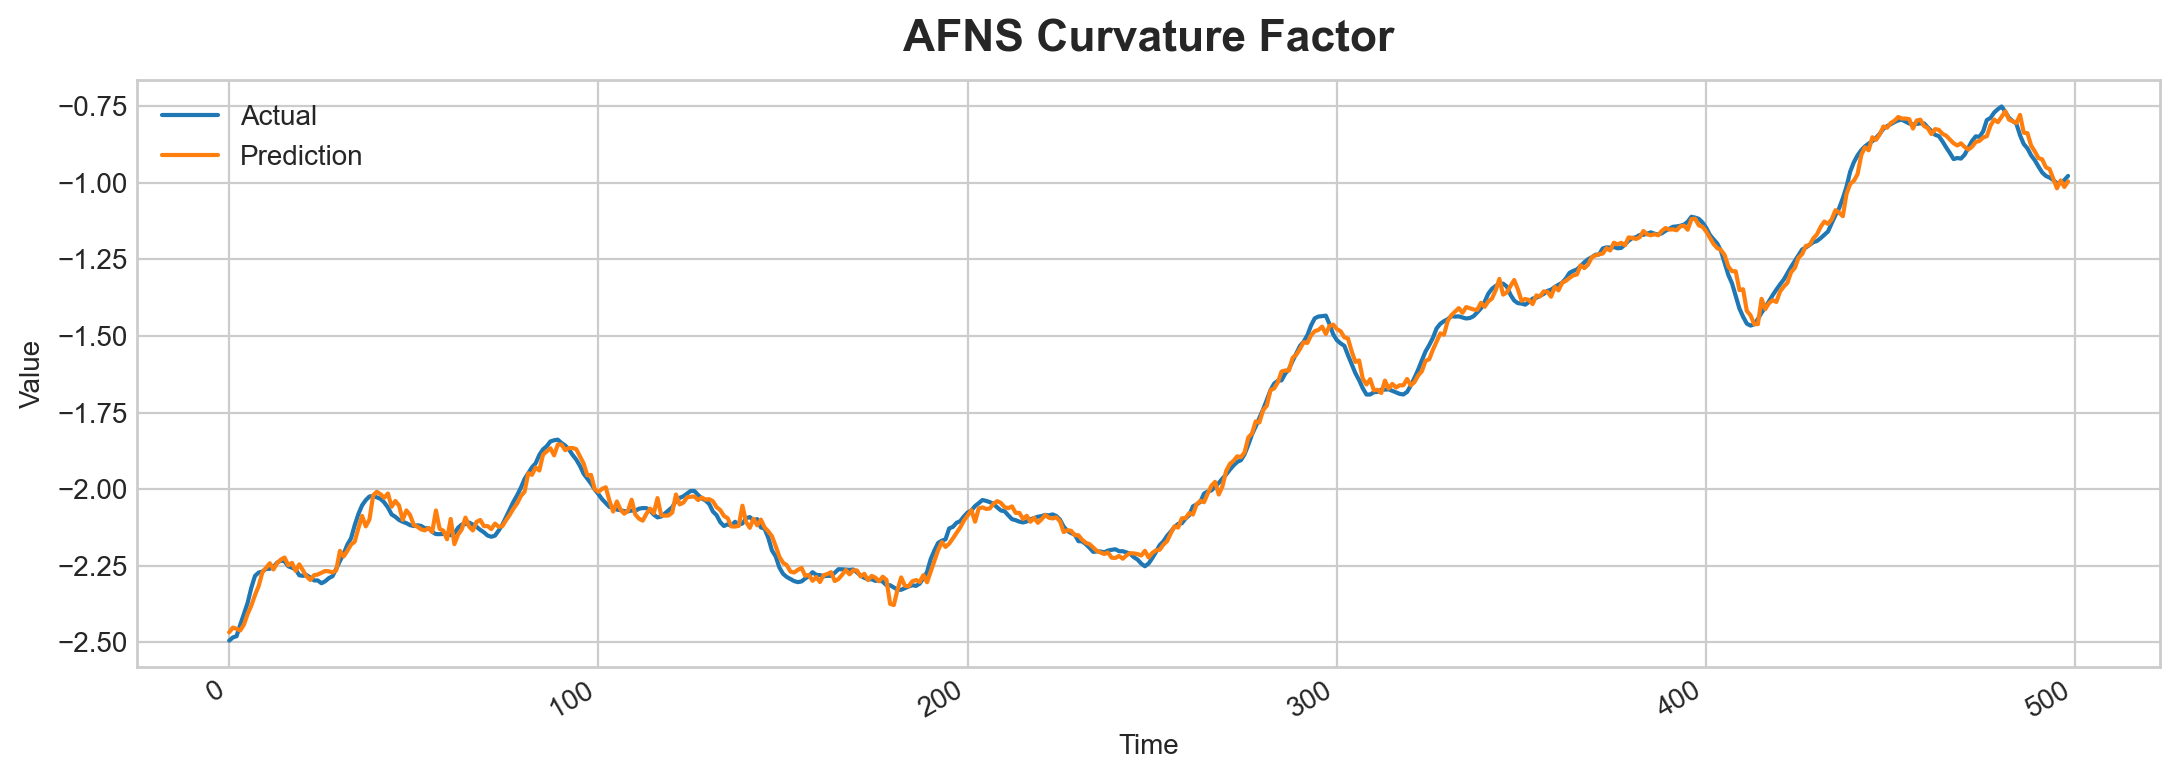

In [28]:
plot_predict(beta2_test_y.values, beta2_predict_list, label="Curvature")

## 合并数据

In [24]:
# data
result_df = pd.DataFrame()
result_y = y[train_len:]
result_df['Date'] = result_y.index
result_df['Level'] = beta0_predict_list
result_df['Slope'] = beta1_predict_list
result_df['Curvature'] = beta2_predict_list
result_df

,Date,Level,Slope,Curvature
0,2021-01-04,7.644379,-5.306636,-2.467072
1,2021-01-05,7.640732,-5.244631,-2.451434
2,2021-01-06,7.635047,-5.244247,-2.455501
3,2021-01-07,7.630894,-5.245158,-2.460987
4,2021-01-08,7.623591,-5.273683,-2.441818
...,...,...,...,...
494,2022-12-26,6.436063,-4.519201,-0.986718
495,2022-12-27,6.438586,-4.519710,-1.018240
496,2022-12-28,6.440177,-4.512620,-0.992637
497,2022-12-29,6.438803,-4.513036,-1.013793


In [25]:
result_df.to_csv(result_file, index=False, encoding="utf-8-sig")